In [1]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

In [ ]:
!pip install tqdm
!pip install pyro-ppl==1.4.0
!pip install matplotlib
!pip install pytest

In [ ]:
import os
os.getcwd()

'/content'

In [ ]:
os.chdir('/content/drive/MyDrive/Deep_Learning/TyXe')

In [ ]:
os.getcwd()

'/content/drive/MyDrive/Deep_Learning/TyXe'

In [ ]:
!pip install -e .

Obtaining file:///content/drive/MyDrive/Deep_Learning/TyXe
  Attempting uninstall: tyxe
    Found existing installation: tyxe 0.0.1
    Can't uninstall 'tyxe'. No files were found to uninstall.
  Running setup.py develop for tyxe


In [ ]:
import math
import torch
from torch import nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.nn.modules.utils import _pair

import numpy as np
import matplotlib.pyplot as plt

import os
from os.path import exists, join, basename
from os import makedirs, remove
from tqdm.notebook import tqdm

import urllib
import tarfile
import imageio
from torchvision.transforms import Compose, CenterCrop, ToTensor, Resize
import tyxe

In [ ]:
def download_bsd300(dest="dataset"):
    output_image_dir = join(dest, "BSD300/images")

    if not exists(output_image_dir):
        makedirs(dest)
        url = "http://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300-images.tgz"
        print("downloading url ", url)

        data = urllib.request.urlopen(url)

        file_path = join(dest, basename(url))
        with open(file_path, 'wb') as f:
            f.write(data.read())
        with tarfile.open(file_path) as tar:
            for item in tar:
                tar.extract(item, dest)

        remove(file_path)

    return output_image_dir
#if not exists(r'/content/drive/MyDrive/Deep_Learning/dataset'):
#     download_bsd300()

In [ ]:
torch.cuda.is_available()

False

In [ ]:
upscale = 2
center_crop = 200
input_transform = Compose(
    [ToTensor(),
    CenterCrop(center_crop),
    Resize(center_crop // upscale)])
target_transform = Compose(
    [ToTensor(),
     CenterCrop(center_crop),
    Resize(center_crop)])


from PIL import Image

class SRDataset(torch.utils.data.Dataset):
    def __init__(self, path_to_images, transform=None):
        self.path_to_images = path_to_images
        self.transform = transform

    def __len__(self):
      return len(os.listdir(self.path_to_images))

    def __getitem__(self, i):
        self.imagepath = join(
            self.path_to_images,
            os.listdir(self.path_to_images)[i],
        )
        img = Image.open(self.imagepath)#.convert('YCbCr')
        #y, _, _ = img.split()

        input = input_transform(img.copy())
        target = target_transform(img.copy())
        return input, target
      
train_set = SRDataset(r'/content/drive/MyDrive/Deep_Learning/TyXe/dataset/BSDS300/images/train')
test_set = SRDataset(r'/content/drive/MyDrive/Deep_Learning/TyXe/dataset/BSDS300/images/test')

In [ ]:
for X, y in train_set:
  break

In [ ]:
y.shape

torch.Size([3, 200, 200])

In [ ]:
# plt.imshow(train_set[0][0].squeeze(0).numpy(), cmap='gray')
# plt.imshow(train_set[0][1].squeeze(0).numpy(), cmap='gray')

In [ ]:
class CNN(nn.Module):
    def __init__(self, upscale):
        self.upscale = upscale

        super(CNN, self).__init__()
        self.relu = nn.ReLU()
        self.tanh = torch.nn.Tanh()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, stride=1, padding=2)
        #self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(32, 3 * self.upscale**2, kernel_size=3, stride=1, padding=1)
        self.psh = nn.PixelShuffle(self.upscale)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        #x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.conv4(x)
        x = self.psh(x)

        return self.tanh(x)

test = CNN(2)
print(test(torch.rand(1, 3, 100, 100)).shape)

torch.Size([1, 3, 200, 200])


In [ ]:
import pyro
import pyro.distributions as dist

training_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=200, shuffle=True)
testing_loader =  torch.utils.data.DataLoader(dataset=test_set, batch_size=1, shuffle=False)

prior = tyxe.priors.IIDPrior(dist.Normal(0, 1))
likelihood = tyxe.likelihoods.HomoskedasticGaussian(len(train_set), scale=0.1)
inference = tyxe.guides.AutoNormal
bnn = tyxe.VariationalBNN(test, prior, likelihood, inference)

In [ ]:
pyro.clear_param_store()
optim = pyro.optim.Adam({"lr": 1e-3})
elbos = []
count = 0
def callback(bnn, i, e):
    elbos.append(e)
    count =+ 1
    print(e)
    count = 0

bnn.fit(training_loader, optim, 50, callback)

1453599616.0
1296984192.0
1273993344.0
1316035200.0
1185877248.0
1081704960.0
1002447616.0
1160722048.0
1100585984.0
1079954304.0
1005466240.0
854875904.0
864864128.0
696908224.0
932139200.0
645899584.0
699233728.0
874383232.0
677160384.0
655257024.0
692542592.0
633345984.0
653338368.0
469158624.0
731886464.0
640732928.0
633289088.0
623267456.0
648519232.0
628135296.0
623487232.0
625840384.0
631110400.0
628421312.0
633143104.0
455156480.0
628398400.0
624601600.0
727001216.0
617968000.0
595568896.0
616845632.0
597981248.0
451834720.0
618194560.0
615841792.0
450591392.0
612639808.0
494988768.0
593165248.0


In [ ]:
torch.save(bnn._pyro_params, 'bnn')

In [ ]:

path =r'/content/drive/MyDrive/Deep_Learning/TyXe/dataset/BSDS300/images/train/100075.jpg'
img = Image.open(path).convert('YCbCr')
y, cb, cr = img.split()

input = input_transform(y)
#input = input.view(1, -1, y.size[1], y.size[0])
#input = input_transform(y).unsqueeze(0)
input = input_transform(y).unsqueeze(0)
#model = model.eval().cuda()
#input = input.cuda()

out, kl = bnn.predict(input)
out = out.squeeze(0)

(200, 200)


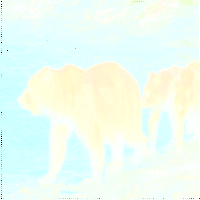

In [ ]:
out_img_y = out[0].data.numpy()
out_img_y *= 255.0
out_img_y = out_img_y.clip(0, 255)
print(out_img_y.shape)
out_img_y = Image.fromarray(np.uint8(out_img_y), mode='L')

out_img_cb = cb.resize(out_img_y.size, Image.BICUBIC)
out_img_cr = cr.resize(out_img_y.size, Image.BICUBIC)
out_img = Image.merge('YCbCr', [out_img_y, out_img_cb, out_img_cr]).convert('RGB')
out_img

In [ ]:
np.array(out_img)[:,:,2]

array([[239, 240, 240, ..., 244, 249, 253],
       [244, 242, 242, ..., 239,   0, 253],
       [251, 249, 246, ..., 233, 246, 255],
       ...,
       [249, 249, 249, ..., 246, 246, 247],
       [249, 249, 249, ..., 249, 247, 247],
       [253, 253, 255, ..., 249, 248, 246]], dtype=uint8)